In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import Corpus

In [3]:
os.chdir('convokit/thread_generator')

In [4]:
from convokit.thread_generator import ThreadSpawner

In [5]:
# focused -> expansionary
t_spawner1 = ThreadSpawner(participant_factor=20, recip_factor=lambda k: 0.9-(0.8)*int(k//11), expansion_factor=lambda k: 1-(0.6)**k)
utts = t_spawner1.spawn_thread(thread_index=1, length=20)
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 1
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
                5. 0x1
                    6. 0x2
                        7. 0x1
                            8. 0x2
                                9. 0x1
                                    10. 0x2
    11. 0x8
    12. 0x11
    13. 0x16
        14. 0x8
    15. 0x23
        20. 0x1
    16. 0x7
    17. 0x1b
    18. 0x24
    19. 0x20


In [6]:
# # expansionary -> focused
# t_spawner2 = ThreadSpawner(participant_factor=100, recip_factor=lambda k: 1-(0.9)**k, expansion_factor=lambda k: (0.95)**k)
# utts = t_spawner2.spawn_thread(thread_index=1, length=20)
# for idx, utt in enumerate(utts):
#     utt.meta['order'] = idx + 1
#     utt.meta['class'] = 2
# Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

In [7]:
# expansionary -> focused
t_spawner2 = ThreadSpawner(participant_factor=20, recip_factor=lambda k: 0.1+(0.8)*int(k//11), expansion_factor=lambda k: (0.95)**k)
utts = t_spawner2.spawn_thread(thread_index=1, length=20) # 11 because k is indexed from 3 to 20
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 2
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)

1. 0x1
    2. 0x2
        8. 0x18
        10. 0xf
            11. 0x17
    3. 0x11
        5. 0x2
        9. 0x17
    4. 0x6
    6. 0x3
        7. 0x2
    12. 0x18
        13. 0x17
            14. 0x18
                15. 0x17
                    16. 0x18
                        17. 0x17
                            18. 0x18
                                19. 0x17
                                    20. 0x18


In [8]:
# dyadic chain
t_spawner3 = ThreadSpawner(participant_factor=4, recip_factor=lambda k: 0.9, expansion_factor=lambda k: 0.2)
utts = t_spawner3.spawn_thread(thread_index=1, length=20)
for idx, utt in enumerate(utts):
    utt.meta['order'] = idx + 1
    utt.meta['class'] = 3
Corpus(utterances=utts).get_conversation('1-1').print_conversation_structure(lambda utt: str(utt.meta['order']) + ". " + utt.user.id)    

1. 0x1
    2. 0x2
        3. 0x1
            4. 0x2
                5. 0x1
                11. 0x5
                    12. 0x8
                        13. 0x5
                            14. 0x8
                                15. 0x5
                                    16. 0x8
                                        17. 0x5
                                            18. 0x8
                                                19. 0x5
                                                    20. 0x8
    6. 0x8
        7. 0x1
            8. 0x8
                9. 0x1
                    10. 0x8


## Corpus generation

In [9]:
all_utts = []

In [34]:
group_size = 1500

In [35]:
LENGTH=20
for thread_idx in range(1, group_size+1):
    utts = t_spawner1.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '1.focused->expansionary'
    all_utts.extend(utts)

for thread_idx in range(group_size+1, 2*group_size+1):
    utts = t_spawner2.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '2.expansionary->focused'
    all_utts.extend(utts)
    
for thread_idx in range(2*group_size+1, 3*group_size+1):
    utts = t_spawner3.spawn_thread(thread_idx, length=LENGTH)
    for utt in utts: utt.meta['subreddit'] = '3.dyadic_chain'
    all_utts.extend(utts)


In [36]:
len(all_utts)

109980

In [37]:
corpus = Corpus(utterances=all_utts)

In [38]:
corpus.print_summary_stats()

Number of Speakers: 40
Number of Utterances: 90000
Number of Conversations: 4500


In [39]:
from functools import reduce

In [40]:
for convo in corpus.iter_conversations():
    convo.meta['prob'] = reduce(lambda x, y: x * y, [utt.meta['prob'] for utt in convo.iter_utterances()])

## Quantize(?) the probs

In [41]:
from collections import defaultdict
from sklearn.preprocessing import QuantileTransformer
import numpy as np

In [42]:
for convo in corpus.iter_conversations():
    convo.meta['group'] = int(next(convo.iter_utterances()).meta['subreddit'][0])

In [43]:
probs = defaultdict(list)
for convo in corpus.iter_conversations():
    probs[convo.meta['group']].append(convo.meta['prob'])

In [44]:
import seaborn as sns

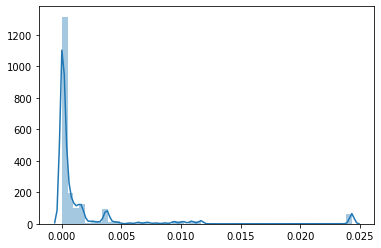

In [45]:
sns.distplot(probs[1])

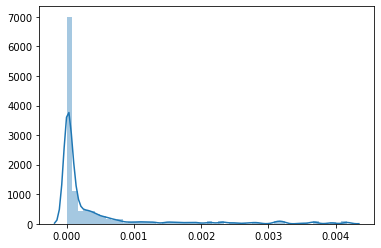

In [46]:
sns.distplot(probs[2])

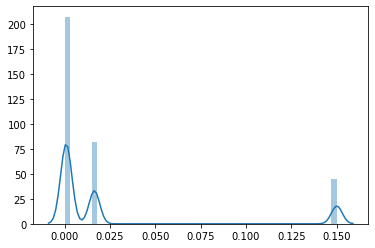

In [47]:
sns.distplot(probs[3])

In [48]:
qt = QuantileTransformer(n_quantiles=18)

In [49]:
percentiles = defaultdict(list)
for k, v in probs.items():
    probs[k] = np.array(v).reshape(-1, 1)
    mm = QuantileTransformer(n_quantiles=18)
    percentiles[k] = mm.fit_transform(probs[k])

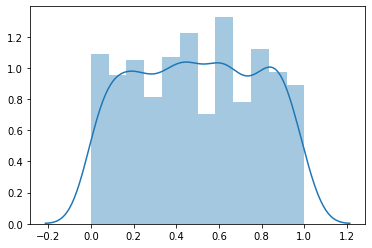

In [50]:
sns.distplot(qt.fit_transform(probs[1]))

In [51]:
for idx, convo in enumerate(corpus.iter_conversations()):
    convo.meta['percentile'] = percentiles[convo.meta['group']][idx % 333][0]

In [52]:
next(corpus.iter_conversations()).meta['percentile']

0.1208424333082472

In [53]:
from convokit import HyperConvo

In [54]:
hyperconv_range = range(2, 20+1)

In [55]:
for hc_idx in hyperconv_range:
    hc = HyperConvo(prefix_len=hc_idx, feat_name="hyperconvo-{}".format(hc_idx), invalid_val=-1)
    hc.fit_transform(corpus)

In [56]:
# corpus = Corpus(filename='annotated-fake-trajectory-2')

In [57]:
corpus.dump('annotated-fake-trajectory-4', base_path='.')